# Прогнозирование стоимости автомобиля по характеристикам

## Подключаем библиотеки

In [1]:
import re
import sys
import ast
import json
import numpy as np
import pandas as pd
import requests
import pandas.api.types as at
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from bs4 import BeautifulSoup
from datetime import timedelta, datetime, date

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
VERSION    = 6
DIR_TRAIN  = '../input/autoru-04032021/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

pd.set_option('display.max_columns', 50)

# 1. Данные

## 1.1 Загрузка данных

Тренировочный датасет я подготовил на локальной машине. Сюда прикладываю закомментированный код, который формирует файл "autoru_02032021.csv"

In [7]:
"""Функция сбора данных с объявления на auto.ru
   На вход получает ссылку на объявление
   На выходе - словарь с собранными данными"""

# def car_detail(url):
#     response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
#     response.encoding = 'utf-8'
#     soup = BeautifulSoup(response.text, 'html.parser')
#     url_dict = {}
#     
#     if 'Этот автомобиль уже продан' in soup.text:
#         return url_dict
#     
#     # Изучив предложенные тестовые и тренировочные данные, а также html страницу с объявлениями
#     # я нашел, что большая часть информации об автомобиле находится
#     # в тегах 'script' с type='application/ld+json'
#     
#     try:
#         json_page_1 = json.loads(soup.find_all('script', attrs = {'type':'application/ld+json'})[0].text)
#         json_page_2 = json.loads(soup.find_all('script', attrs = {'type':'application/ld+json'})[1].text)
#         json_page_3 = json.loads(soup.find('div', attrs = {'id': 'sale-data-attributes'}).attrs['data-bem'])
#         
#     except(KeyError, IndexError):
#         return url_dict
# 
#     try:
#         url_dict['car_url'] = url
# 
#         url_dict['bodyType'] = json_page_1['bodyType']
#         url_dict['brand'] = json_page_1['brand']
#         url_dict['color'] = json_page_1['color']
#         url_dict['description'] = json_page_1['description']
#         url_dict['modelDate'] = json_page_1['modelDate']
#         url_dict['numberOfDoors'] = json_page_1['numberOfDoors']
#         url_dict['productionDate'] = json_page_1['productionDate']
#         url_dict['numberOfDoors'] = json_page_1['numberOfDoors']
#         url_dict['vehicleConfiguration'] = json_page_1['vehicleConfiguration']
#         url_dict['vehicleTransmission'] = json_page_1['vehicleTransmission']
#         url_dict['image'] = json_page_1['image']
#         url_dict['engineDisplacement'] = json_page_1['vehicleEngine']['engineDisplacement']
#         url_dict['enginePower'] = json_page_1['vehicleEngine']['enginePower']
#         url_dict['fuelType'] = json_page_1['vehicleEngine']['fuelType']
#         url_dict['price'] = int(json_page_1['offers']['price'])
#         url_dict['priceCurrency'] = json_page_1['offers']['priceCurrency']
# 
#         url_dict['name'] = json_page_2['itemListElement'][3]['name']
# 
#         url_dict['model_name'] = json_page_3['sale-data-attributes']['model']
#         url_dict['mileage'] = int(json_page_3['sale-data-attributes']['km-age'])
# 
#         url_dict['Владельцы'] = soup.find('li', class_ = 'CardInfoRow CardInfoRow_ownersCount').find_all('span', class_='CardInfoRow__cell')[1].text.replace(u'\xa0', u' ')
#         url_dict['ПТС'] = soup.find('li', class_ = 'CardInfoRow CardInfoRow_pts').find_all('span', class_='CardInfoRow__cell')[1].text
#         url_dict['Привод'] = soup.find('li', class_ = 'CardInfoRow CardInfoRow_drive').find_all('span', class_='CardInfoRow__cell')[1].text
#         url_dict['Руль'] = soup.find('li', class_ = 'CardInfoRow CardInfoRow_wheel').find_all('span', class_='CardInfoRow__cell')[1].text
#         url_dict['Таможня'] = soup.find('li', class_ = 'CardInfoRow CardInfoRow_customs').find_all('span', class_='CardInfoRow__cell')[1].text
#         url_dict['Состояние'] = soup.find('li', class_ = 'CardInfoRow CardInfoRow_state').find_all('span', class_='CardInfoRow__cell')[1].text
# 
#         complectation = []
#         for complect in soup.find_all('li', class_='ComplectationGroups__itemContentEl'):
#             complectation.append(complect.text)
#         url_dict['complectation_dict'] = complectation
#         
#     except(KeyError, ValueError, AttributeError):
#         pass
#     
#     return url_dict

'Функция сбора данных с объявления на auto.ru\n   На вход получает ссылку на объявление\n   На выходе - словарь с собранными данными'

In [8]:
# brands = ['bmw', 'volkswagen', 'nissan', 'mercedes', 'toyota', 'audi', 
#           'mitsubishi', 'skoda', 'volvo', 'honda', 'infiniti', 'lexus']
# 
# # Собираем словарь, в котором сохраним ссылки на объявления по интересующим нас маркам автомобилей
# 
# cars_urls = {}
# url = 'https://auto.ru/cars/'
# 
# for car_brand in brands:
#     brand_url = url + car_brand + '/used/?page=' #собираем url для поиска по каждому бренду
#     cars_urls[car_brand] = []
#     
#     for number in range(1, 100): # Опытным путем выяснили, что по каждому поиску отображается не более 100 страниц
#         response = requests.get(brand_url+str(number), headers={'User-Agent': 'Mozilla/5.0'})
#         page = BeautifulSoup(response.text, 'html.parser')
#         link_list = page.find_all('a', class_='Link ListingItemTitle-module__link')
#         
#         if len(link_list) !=0: #если попытаемся перейти на страницу, которой не существует, то на ней просто не будет объявлений
# 
#             for link in link_list:
#                 cars_urls[car_brand].append(link['href'])
#         
#         else:
#             break
#     
#     print('{}: Объявлений по марке {}: {}'.format(datetime.now(), car_brand, len(cars_urls[car_brand])))

In [9]:
# # Запустим цикл, чтобы собрать по всем объявлениям детальную информацию
# # и записать ее в DataFrame
# 
# columns = ['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
#       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
#       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
#       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
#       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
#       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
#        'Привод', 'Руль', 'Состояние', 'Таможня', 'price']
# df_train = pd.DataFrame(columns=columns)
# 
# print('Старт {}'.format(datetime.now()))
# 
# for car_brand in brands:
#     counter = 0
#     
#     for car_url in cars_urls[car_brand]:
#         counter += 1
#         df_train.loc[len(df_train)] = pd.Series(car_detail(car_url))
#         
#         if counter == len(cars_urls[car_brand])//4:
#             print('{}: Четверть ссылок по марке {} обработана'.format(datetime.now(), car_brand))
#         
#         if counter == len(cars_urls[car_brand])//2:
#             print('{}: Половина ссылок по марке {} обработана'.format(datetime.now(), car_brand))
#         
#         if counter == len(cars_urls[car_brand]):
#             print('{}: Все ссылки по марке {} обработаны'.format(datetime.now(), car_brand))
# 
# print('Конец {}'.format(datetime.now()))
# 
# # В полученном датафрейме удалим пустые строки
# df_train.dropna(axis=0, how = 'all', inplace=True)

In [10]:
# df_train.to_csv('autoru_02032021.csv')

In [11]:
!ls '../input'

autoru-04032021  sf-dst-car-price-prediction


In [12]:
train = pd.read_csv(DIR_TRAIN+'autoru_04032021.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [13]:
train.sample(3).T

,20254,149,2441
Unnamed: 0,31161,157,2612
bodyType,седан,универсал 5 дв.,седан
brand,AUDI,BMW,BMW
car_url,https://auto.ru/cars/used/sale/audi/a6/1102315...,https://auto.ru/cars/used/sale/bmw/5er/1101524...,https://auto.ru/cars/used/sale/bmw/5er/1102465...
color,серый,чёрный,белый
complectation_dict,[],"['Антипробуксовочная система (ASR)', 'Система ...","['Антипробуксовочная система (ASR)', 'Система ..."
description,Пpодaю cвою АУДИ A6. Pасходники пoменяны. Mаши...,"Автомобиль в идеальнейшем состоянии, приобрета...",BMW 5 серия VI (F10/F11/F07) Рестайлинг 528i x...
engineDisplacement,2.8 LTR,3.0 LTR,2.0 LTR
enginePower,220 N12,313 N12,245 N12
equipment_dict,NaN,NaN,NaN


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38104 entries, 0 to 38103
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            38104 non-null  int64  
 1   bodyType              38081 non-null  object 
 2   brand                 38082 non-null  object 
 3   car_url               38104 non-null  object 
 4   color                 38082 non-null  object 
 5   complectation_dict    38073 non-null  object 
 6   description           38082 non-null  object 
 7   engineDisplacement    38080 non-null  object 
 8   enginePower           38080 non-null  object 
 9   equipment_dict        0 non-null      float64
 10  fuelType              38080 non-null  object 
 11  image                 38080 non-null  object 
 12  mileage               38080 non-null  float64
 13  modelDate             38081 non-null  float64
 14  model_info            0 non-null      float64
 15  model_name         

In [15]:
test.sample(3).T

,7855,11256,29524
bodyType,внедорожник 5 дв.,внедорожник 5 дв.,седан
brand,BMW,NISSAN,BMW
car_url,https://auto.ru/cars/used/sale/bmw/x3/11012945...,https://auto.ru/cars/used/sale/nissan/x_trail/...,https://auto.ru/cars/used/sale/bmw/6er/1101310...
color,бежевый,белый,синий
complectation_dict,NaN,NaN,"{""id"":""20510251"",""name"":""640d xDrive"",""availab..."
description,Автомобиль в отличном состоянии и по кузову и ...,РОЛЬФ Премиум – крупнейший официальный дилер М...,По факту один владелец!Полностью обслужен и ис...
engineDisplacement,3.0 LTR,2.0 LTR,3.0 LTR
enginePower,258 N12,144 N12,313 N12
equipment_dict,NaN,"{""fabric-seats"":true}","{""cruise-control"":true,""esp"":true,""usb"":true,""..."
fuelType,бензин,бензин,дизель


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## 1.2 Подготовка данных

Выберем из train и test те колонки, которые, потенциально, можно будет использовать в модели.
В выборку не включаем следующие колонки:
 * **car_url** - ссылка на объявление, не несет полезной информации
 * **equipment_dict** - мне не удалось собрать аналогичную информацию для train. Да и в test в этой колонке перечислены комплектующие, которые также перечислены в complectation_dict
 * **image** - ссылка на картинку из обхявления, не несет полезной информации
 * **model_info** - дублирует информацию из model_name и name
 * **parsing_unixtime** - время загрузки объявления, не несет полезной информации
 * **priceCurrency** - и в train и в test имеет одно значение - RUB, не несет полезной информации
 * **sell_id** - id объявления, не несет полезной информации
 * **super_gen** - информацию о марке автомобиля, не смог добыть аналогичную информацию для train
 * **vehicleConfiguration** - дублирует информацию из model_name и vehicleTransmission
 * **vendor** - производитель автомобиля (европа или азия) не смог добыть аналогичную информацию для train
 * **Владение** - срок владения автомобилем, не смог добыть аналогичную информацию для train
 * **Состояние** - состояние автомобиля, везде одно значение - "Не требует ремонта", не несет полезной информации
 * **Таможня** - информация о том, растаможен ли автомобиль или нет, везде одно значение, не несет полезной информации

In [17]:
df_train = train[['bodyType', 'brand', 'color', 'complectation_dict', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name', 'name',
       'numberOfDoors', 'productionDate', 'vehicleTransmission', 
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'price']]
df_train.dropna(axis=0, how = 'all', inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
df_test = test[['bodyType', 'brand', 'color', 'complectation_dict', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name', 'name',
       'numberOfDoors', 'productionDate', 'vehicleTransmission', 
       'Владельцы', 'ПТС', 'Привод', 'Руль']]

### 1.2.1 bodyType

In [19]:
# Удалим из train записи, у которых bodyType отличается от списка из test
body_type_list_test = list(df_test['bodyType'].unique())

def get_bodyType(x, body_type_list):
    for t_bodyType in body_type_list:
        if t_bodyType == x:
            return t_bodyType
        else: continue
    return '0'
    
df_train['bodyType'] = df_train['bodyType'].apply(lambda x: get_bodyType(x, body_type_list_test))
df_train = df_train[df_train['bodyType'] !='0']
df_train['bodyType'].value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



внедорожник 5 дв.          15764
седан                      12582
лифтбек                     2733
хэтчбек 5 дв.               2177
универсал 5 дв.             1234
купе                         907
минивэн                      900
компактвэн                   547
пикап двойная кабина         390
хэтчбек 3 дв.                314
внедорожник 3 дв.            203
кабриолет                     74
купе-хардтоп                  74
фургон                        63
родстер                       61
микровэн                      25
седан-хардтоп                  8
пикап одинарная кабина         8
пикап полуторная кабина        7
седан 2 дв.                    3
фастбек                        2
внедорожник открытый           1
тарга                          1
Name: bodyType, dtype: int64

### 1.2.2 engineDisplacement

In [20]:
# Оставим в признаке только число
df_test['engineDisplacement'] = df_test['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))
df_train['engineDisplacement'] = df_train['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 1.2.3 enginePower

In [21]:
# Оставим в признаке только число
df_test['enginePower'] = df_test['enginePower'].apply(lambda x: 0 if str(x)[:-4] == '' else int(str(x)[:-4]))
df_train['enginePower'] = df_train['enginePower'].apply(lambda x: 0 if str(x)[:-4] == '' else int(str(x)[:-4]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 1.2.4 complectation_dict

In [22]:
# Распарсим стобец complectation_dict в test
def parse_test_complectation(value):
    if value != value or pd.isnull(value):
        return []
    
    json_complectation = json.loads(value)
    values = json_complectation['available_options']
    return values

df_test['complectation'] = df_test['complectation_dict'].apply(parse_test_complectation)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
# Соберем все уникальные названия в признаке комплектации
complectation_test = defaultdict(int)

for value in df_test['complectation']:
    if value == value and value != None:
        for item in value:
            complectation_test[item] += 1

# Выберем 30 наиболее часто встречающихся
sort_complectation = sorted(complectation_test.items(), key = lambda x: x[1], reverse=True)
most_frequent_num = 30
most_frequent_items = []

for item in sort_complectation[:most_frequent_num]:
    most_frequent_items.append(item[0])

In [24]:
print(most_frequent_items)

['airbag-driver', 'electro-window-front', 'wheel-configuration1', 'abs', 'immo', 'lock', 'airbag-passenger', 'mirrors-heat', 'electro-mirrors', 'computer', 'audiopreparation', 'wheel-configuration2', 'electro-window-back', 'airbag-side', 'esp', 'front-seats-heat', 'audiosystem-cd', 'seat-transformation', 'ptf', 'climate-control-1', 'isofix', 'condition', 'wheel-leather', 'multi-wheel', 'airbag-curtain', 'cruise-control', 'aux', 'third-rear-headrest', 'front-centre-armrest', 'rain-sensor']


In [25]:
# Распарсим столбец complectation_dict в df_train
def parse_train_complectation(value):
    if value != value or pd.isnull(value):
        return []
    
    value = ast.literal_eval(value)
    
    # Составим словарь соответствия названий комплектующих на рускком (в train) и английском (в test)
    # по самым часто встречающимся в test значениям 
    dict_components = {'Круиз-контроль':'cruise-control',
                       'Противотуманные фары':'ptf',
                       'Крепление детского кресла (задний ряд) ISOFIX':'isofix',
                       'Отделка кожей рулевого колеса':'wheel-leather',
                       'Подушки безопасности оконные (шторки)':'airbag-curtain',
                       'AUX':'aux',
                       'Третий задний подголовник':'third-rear-headrest',
                       'Передний центральный подлокотник':'front-centre-armrest',
                       'Система стабилизации (ESP)':'esp',
                       'Антиблокировочная система (ABS)':'abs',
                       'Подушка безопасности водителя':'airbag-driver',
                       'Подушка безопасности пассажира':'airbag-passenger',
                       'Электростеклоподъёмники передние':'electro-window-front',
                       'Центральный замок':'lock',
                       'Регулировка руля по вылету':'wheel-configuration1',
                       'Регулировка руля по высоте':'wheel-configuration2',
                       'Иммобилайзер':'immo',
                       'Электрообогрев боковых зеркал':'mirrors-heat',
                       'Электропривод зеркал':'electro-mirrors',
                       'Аудиоподготовка':'audiopreparation',
                       'Подогрев передних сидений':'front-seats-heat',
                       'Складывающееся заднее сиденье':'seat-transformation',
                       'Климат-контроль 1-зонный':'climate-control-1',
                       'Кондиционер':'condition',
                       'Бортовой компьютер':'computer',
                       'Аудиосистема':'audiosystem-cd',
                       'Электростеклоподъёмники задние':'electro-window-back',
                       'Подушки безопасности боковые':'airbag-side',
                       'Датчик дождя':'rain-sensor',
                       'Мультифункциональное рулевое колесо':'multi-wheel'}
    result = []
    
    for comp in value:
        try:
            result.append(dict_components[comp])
        except(KeyError):
            continue    
   
    return result

df_train['complectation'] = df_train['complectation_dict'].apply(parse_train_complectation)

### 1.2.5 Владельцы

In [26]:
# Оставим только цифры
df_test['owners'] = df_test['Владельцы'].apply(lambda x: str(x).replace(u'\xa0', u' ')).map({'3 или более':3, 
                                                                                             '2 владельца':2, 
                                                                                             '1 владелец':1})

df_train['owners'] = df_train['Владельцы'].apply(lambda x: str(x).replace(u'\xa0', u' ')).map({'3 или более':3, 
                                                                                               '2 владельца':2, 
                                                                                               '1 владелец':1})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 1.2.6 Удаляем лишнее

In [27]:
df_test.drop(['complectation_dict', 'Владельцы'], axis=1, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             34686 non-null  object
 1   brand                34686 non-null  object
 2   color                34686 non-null  object
 3   description          34686 non-null  object
 4   engineDisplacement   34686 non-null  object
 5   enginePower          34686 non-null  int64 
 6   fuelType             34686 non-null  object
 7   mileage              34686 non-null  int64 
 8   modelDate            34686 non-null  int64 
 9   model_name           34686 non-null  object
 10  name                 34686 non-null  object
 11  numberOfDoors        34686 non-null  int64 
 12  productionDate       34686 non-null  int64 
 13  vehicleTransmission  34686 non-null  object
 14  ПТС                  34685 non-null  object
 15  Привод               34686 non-null  object
 16  Руль

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
df_train.drop(['complectation_dict', 'Владельцы'], axis=1, inplace=True)
df_train.dropna(axis=0, inplace=True)

# Поправим формат некоторых колонок для соответствия с test
df_train['modelDate'] = df_train['modelDate'].astype('int')
df_train['numberOfDoors'] = df_train['numberOfDoors'].astype('int')
df_train['mileage'] = df_train['mileage'].astype('int')
df_train['productionDate'] = df_train['productionDate'].astype('int')
df_train['owners'] = df_train['owners'].astype('int')
df_train['price'] = df_train['price'].astype('int')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38076 entries, 0 to 38103
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             38076 non-null  object
 1   brand                38076 non-null  object
 2   color                38076 non-null  object
 3   description          38076 non-null  object
 4   engineDisplacement   38076 non-null  object
 5   enginePower          38076 non-null  int64 
 6   fuelType             38076 non-null  object
 7   mileage              38076 non-null  int64 
 8   modelDate            38076 non-null  int64 
 9   model_name           38076 non-null  object
 10  name                 38076 non-null  object
 11  numberOfDoors        38076 non-null  int64 
 12  productionDate       38076 non-null  int64 
 13  vehicleTransmission  38076 non-null  object
 14  ПТС                  38076 non-null  object
 15  Привод               38076 non-null  object
 16  Руль

## 1.3 Создаем новые признаки

### 1.3.1 Объединяем датасеты

In [29]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 1.3.2 Скорректируем значение признака engineDisplacement

При обработке выборок я заметил, что чать значений в признаке engineDisplacement пропали (после очистки от 'LTR'). Исправим ситуацию, использовав данные из признака name. Также выделим из name информацию об автмобилях с гибридной силовой установкой

In [30]:
pattern = re.compile('(\d{1}\.\d{1})')

data['engine'] = data['name'].apply(lambda x:str(pattern.findall(str(x)))[2:5])
data['engine'] = pd.to_numeric(data['engine'], errors='coerce')
data['engine'].fillna(0, inplace=True) # Заполним пропуски нулями
data['engine'] = data['engine'].astype('int')

data['hybrid'] = data['name'].apply(lambda x: 1 if 'hyb' in x else 0)

# Удалим дублирующую таблицу
data.drop(['engineDisplacement', 'name'], axis=1, inplace=True)

### 1.3.3 Тип продавца

Информацию о типе продавца (реальный владелец или дилер) попробуем вытащить из описания

In [31]:
data['description'] = data['description'].map(lambda x: str(x).lower())

# Чаще всего реальные владельцы авто пишут, что не нужнаются в перекупщиках и предлагают торг или обмен. 
# А так же мало пишут (маленькая длина объявления)
data['owner'] = data['description'].apply(lambda x: 1 if 'торг' in x 
                                          or 'не нуждаюсь' in x
                                          or 'не беспокоить' in x
                                          or 'обмен' in x
                                          or 'Продаю' in x or 'продаю' in x
                                          or len(x)<100 else 0)

# Дилеры почти в каждом объявлении предлагаю кредит, тред-ид и прочие скидки
data['dealer'] = data['description'].apply(lambda x: 1 if 'traid-in' in x or 'трейд-ин' in x
                                             or 'дилер' in x 
                                             or 'кредит' in x
                                             or 'клиент' in x
                                             or 'без комис' in x
                                             or 'страховани' in x 
                                             or 'в наличии' in x 
                                             or 'выгодное пр' in x 
                                             or 'автокредит' in x 
                                             or 'рынке' in x or 'рынок' in x
                                             else 0)

# Так как ключевые слова для дилеров более явные, снимем флаг owner в тех строках, есть есть флаг dealer
data.loc[data['dealer'] == 1, 'owner'] = 0

# Удалим описания из датасета
data.drop(['description'], axis=1, inplace=True)

display(data['owner'].value_counts())
display(data['dealer'].value_counts())

0    46317
1    26445
Name: owner, dtype: int64

0    41920
1    30842
Name: dealer, dtype: int64

### 1.3.4 Создадим dummy-признаки из complectation

In [32]:
""""Функция проверяет наличие item в переданном value
    При этом, item является глобальной переменной для данной функции"""

def fill_complectation_item(value):
    if item in value:
        return 1
    else:
        return 0

In [33]:
for item in most_frequent_items:
    data[item] = data['complectation'].apply(fill_complectation_item)

data.drop(['complectation'], axis=1, inplace=True)

### 1.3.5 Возраст машины

In [34]:
data['years_old'] = 2021 - data['productionDate']
data.drop(['productionDate'], axis=1, inplace=True)

### 1.3.6 Преобразуем категориальные признаки

In [35]:
for column in ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 
               'ПТС', 'Привод', 'Руль']:
    data[column] = data[column].astype('category').cat.codes

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72762 entries, 0 to 72761
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              72762 non-null  int8   
 1   brand                 72762 non-null  int8   
 2   color                 72762 non-null  int8   
 3   enginePower           72762 non-null  int64  
 4   fuelType              72762 non-null  int8   
 5   mileage               72762 non-null  int64  
 6   modelDate             72762 non-null  int64  
 7   model_name            72762 non-null  int16  
 8   numberOfDoors         72762 non-null  int64  
 9   vehicleTransmission   72762 non-null  int8   
 10  ПТС                   72762 non-null  int8   
 11  Привод                72762 non-null  int8   
 12  Руль                  72762 non-null  int8   
 13  owners                72762 non-null  int64  
 14  sample                72762 non-null  int64  
 15  price              

In [36]:
data.sample(10).T

,33789,69455,66344,35258,21482,70249,32118,14516,59382,26426
bodyType,23.0,1.0,15.0,15.0,23.0,15.0,1.0,15.0,8.0,10.0
brand,0.0,3.0,2.0,1.0,9.0,4.0,6.0,7.0,8.0,10.0
color,1.0,1.0,15.0,1.0,12.0,12.0,12.0,0.0,11.0,6.0
enginePower,180.0,302.0,142.0,249.0,132.0,421.0,170.0,110.0,150.0,174.0
fuelType,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
mileage,92000.0,170000.0,110000.0,16900.0,480000.0,48648.0,133500.0,118500.0,319119.0,150000.0
modelDate,2012.0,2007.0,2011.0,2016.0,2010.0,2017.0,2009.0,2004.0,2000.0,2003.0
model_name,43.0,197.0,122.0,28.0,76.0,318.0,373.0,533.0,365.0,349.0
numberOfDoors,5.0,5.0,4.0,4.0,5.0,4.0,5.0,4.0,5.0,5.0
vehicleTransmission,3.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0


## 1.4 Проверим корреляцию

### 1.4.1 Посмотрим на корреляцию признаков, полученных из complectation

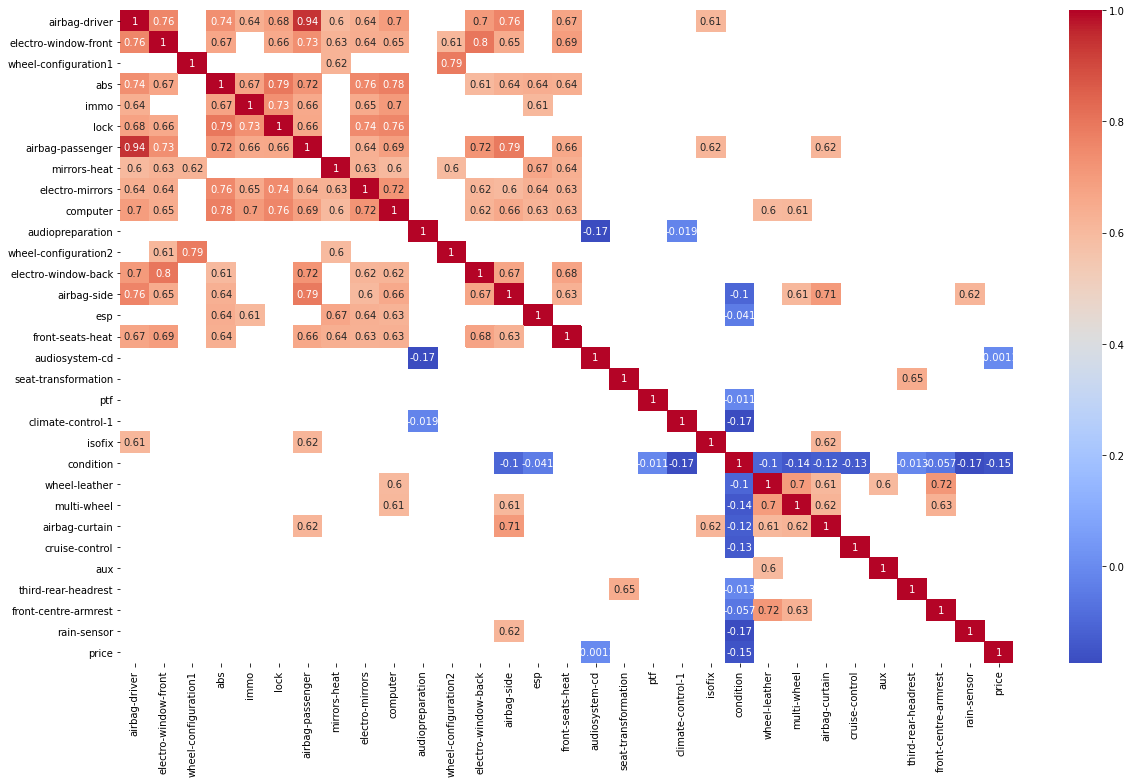

In [37]:
columns_corr = []
columns_corr = most_frequent_items.copy()
columns_corr.append('price')
data_corr = data.query('sample == 1')[columns_corr].corr()

plt.figure(figsize=(20, 12))
sns.heatmap(data_corr[(data_corr >= 0.6) | (data_corr <= 0)], annot=True, cmap='coolwarm')

In [38]:
display(data_corr['price'])

airbag-driver           0.195039
electro-window-front    0.163093
wheel-configuration1    0.099512
abs                     0.164708
immo                    0.185907
lock                    0.143815
airbag-passenger        0.209854
mirrors-heat            0.167947
electro-mirrors         0.171510
computer                0.212704
audiopreparation        0.033683
wheel-configuration2    0.060529
electro-window-back     0.191774
airbag-side             0.267791
esp                     0.194212
front-seats-heat        0.201237
audiosystem-cd         -0.001126
seat-transformation     0.125414
ptf                     0.080046
climate-control-1       0.066642
isofix                  0.260085
condition              -0.154314
wheel-leather           0.267859
multi-wheel             0.299945
airbag-curtain          0.316771
cruise-control          0.199766
aux                     0.181586
third-rear-headrest     0.202396
front-centre-armrest    0.219773
rain-sensor             0.323468
price     

#### Выводы:

Заметим, что признаки **airbag-driver**, **electro-window-front**, **abs**, **immo**, **lock**, **airbag-passenger**, **electro-mirrors**, **computer**, **airbag-side**, **front-seats-heat** коррелируют между собой больше чем на 0.6
Оставим один из них, который больше коррелирует с **price** - **airbag-side**

Так же, сильно коррелируют признаки **wheel-configuration1** и **wheel-configuration2**. Оставим один из них - **wheel-configuration1**

Признак **wheel-configuration1** коррелирует с **mirrors-heat**. Признак **mirrors-heat** коррелирует с **esp**. Удаляем **mirrors-heat**

Еще несколько скоррлированных между собой признаков: **airbag-curtain**, **airbag-side**, **multi-wheel**, **wheel-leather**. Среди них оставляем **airbag-curtain**

Далее, коррелируют **third-rear-headrest** и **seat-transformation**. Оставляем **third-rear-headrest**

И еще пара признаков: **airbag-curtain** и **isofix**. Оставляем **airbag-curtain**

In [39]:
columns_drop = ['airbag-driver', 'electro-window-front', 'abs', 'immo', 'lock', 'airbag-passenger', 
                'electro-mirrors', 'front-seats-heat', 'wheel-configuration2', 'mirrors-heat', 'computer', 
                'airbag-side', 'multi-wheel', 'wheel-leather', 'seat-transformation', 'isofix']

data.drop(columns_drop, axis=1, inplace=True)

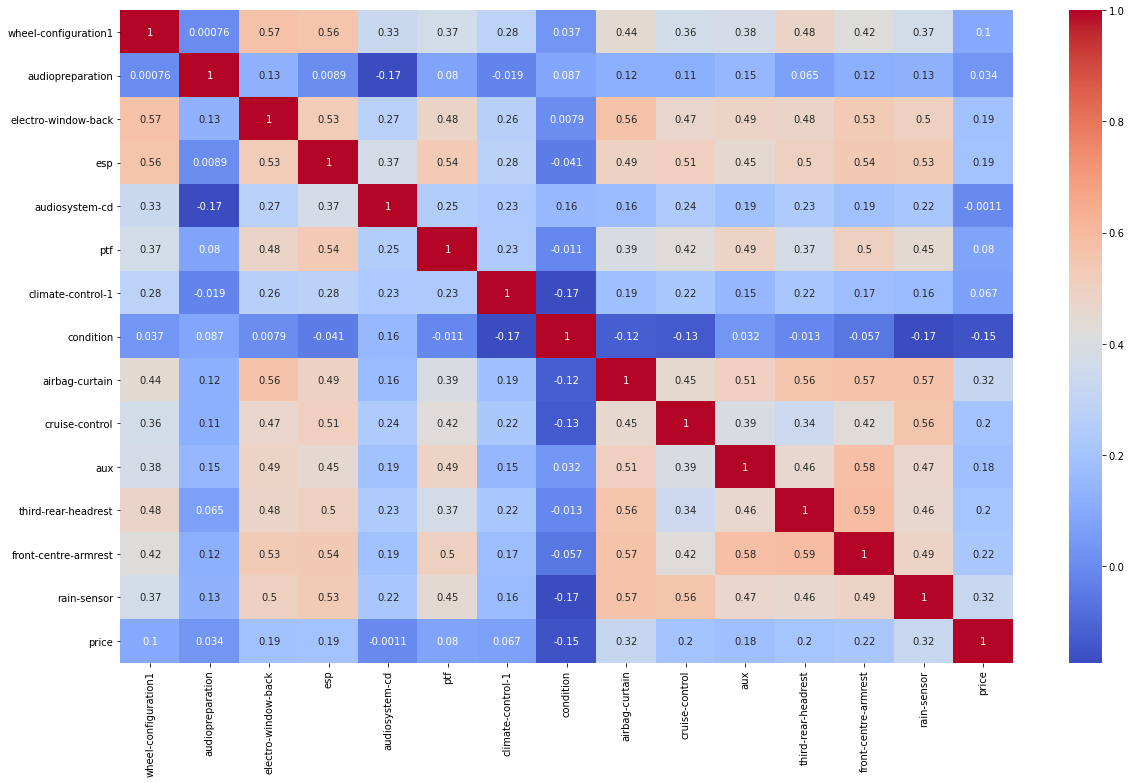

In [40]:
for col in columns_drop:
    columns_corr.remove(col)

data_corr = data.query('sample == 1')[columns_corr].corr()

plt.figure(figsize=(20, 12))
sns.heatmap(data_corr, annot=True, cmap='coolwarm')

### 1.4.2 Корреляция числовых признаков

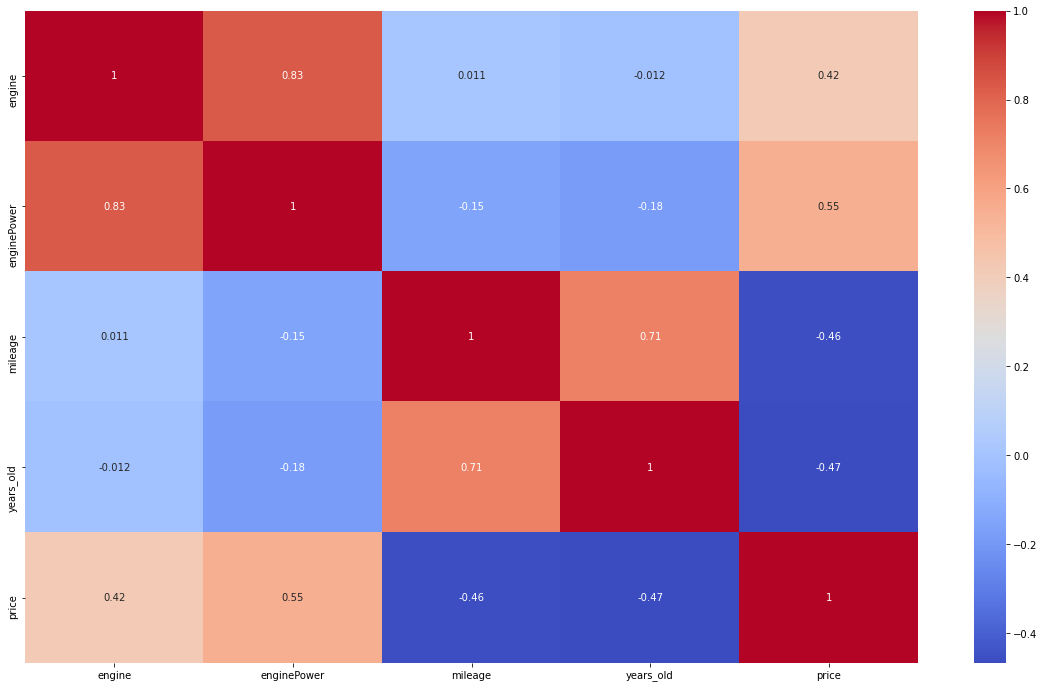

In [41]:
num_cols = ['engine', 'enginePower', 'mileage', 'years_old', 'price']

data_corr = data.query('sample == 1')[num_cols].corr()

plt.figure(figsize=(20, 12))
sns.heatmap(data_corr, annot=True, cmap='coolwarm')

#### Выводы:

Объем (engine) и мощность (enginePower) двигателя сильно скоррелированы между собой. Но оба коррелируют с ценой, так что оставим.

Так же, есть корреляция между возрастом машины (years_old) и пробегом (mileage). Что вполне логично. Но оба признака все равно оставим

## 1.5 Готовим данные для моделей

In [42]:
scaler = MinMaxScaler()

X = data.query('sample == 1').drop(['sample', 'price'], axis=1)
#X_std = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

X_sub = data.query('sample == 0').drop(['sample', 'price'], axis=1)
#X_sub_std = pd.DataFrame(data=scaler.fit_transform(X_sub), columns=X.columns)

In [43]:
X_sub.sample(10).T

,12005,13656,9827,1116,4898,19313,19367,26296,22417,17691
bodyType,15,1,15,19,15,4,1,19,1,15
brand,7,7,1,8,0,9,9,10,4,5
color,11,15,11,12,15,15,12,12,1,15
enginePower,102,174,306,105,200,126,148,150,277,204
fuelType,0,3,0,0,0,3,0,0,0,0
mileage,68279,210000,222222,131000,202000,245621,93294,68000,55000,177000
modelDate,2012,2004,2002,2007,2004,2009,2010,2000,2008,2006
model_name,58,386,28,204,44,569,440,382,456,200
numberOfDoors,4,5,4,5,4,5,5,5,5,4
vehicleTransmission,0,0,0,0,0,2,1,2,0,0


In [44]:
y = data.query('sample == 1')['price']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 2. Моделирование


In [46]:
"""Функция для вывода времени обучения модели и точности метрики MAPE"""

def print_learn_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print(f"Точность по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

## 2.1 CatBoost

### 2.1.1 Fit

In [47]:
# start = datetime.now()
# 
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True)
# 
# model.fit(X_train, y_train,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True)
# 
# model.save_model('catboost_single_model.model')
# 
# predict = model.predict(X_test)
# 
# # оцениваем точность
# print_learn_report(start, y_test, predict)

    Время выполнения -  0:00:31.666172
    Точность по метрике MAPE:14.49%

### 2.1.2 Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    

In [48]:
np.log(y_train)

46437    14.669500
45605    15.319588
50455    15.404746
61639    13.353475
70302    15.301650
           ...    
51536    13.234799
40951    13.251636
45970    16.117996
35546    13.959611
50481    13.859527
Name: price, Length: 30460, dtype: float64

In [49]:
# start = datetime.now()
#  
# cbr_model = CatBoostRegressor(iterations = 5000,
#                               random_seed = RANDOM_SEED,
#                               eval_metric='MAPE',
#                               custom_metric=['R2', 'MAE'],
#                               silent=True)
#  
# cbr_model.fit(X_train, np.log(y_train),         
#               eval_set=(X_test, np.log(y_test)),
#               verbose_eval=0,
#               use_best_model=True)
# 
# cbr_model.save_model('catboost_single_model_2_with_log.model')
#  
# predict_cbr = np.exp(cbr_model.predict(X_test))
#  
# # оцениваем точность
# print_learn_report(start, y_test, predict_cbr)

    Время выполнения -  0:00:31.803131
    Точность по метрике MAPE:12.54%

## 2.2 RandomForest

### 2.2.1 Fit

In [50]:
# start = datetime.now()
# 
# model = RandomForestRegressor(random_state = RANDOM_SEED,  n_jobs = -1)
# model.fit(X_train, np.log(y_train))
# 
# predict_rfr = np.exp(model.predict(X_test))
# print_learn_report(start, y_test, predict_rfr)

    Время выполнения -  0:00:09.213073
    Точность по метрике MAPE:13.21%

### 2.2.2 Подберем гиперпараметры

In [51]:
# rf_param = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
#             'max_features': ['auto', 'sqrt'],
#             'max_depth': [int(x) for x in np.linspace(1, 20, num = 2)] + [None],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4],
#             'bootstrap': [True, False]}
#  
# rfr = RandomForestRegressor(random_state = RANDOM_SEED)
#  
# rf_random = RandomizedSearchCV(estimator = rfr, 
#                                param_distributions = rf_param, 
#                                n_iter = 100, 
#                                cv = 3, 
#                                verbose=10, 
#                                random_state=RANDOM_SEED, 
#                                n_jobs = -1)
# 
# rf_random.fit(X_train, np.log(y_train))
# rf_random.best_params_

**best_params_:**

    {'n_estimators': 1000,
     'min_samples_split': 5,
     'min_samples_leaf': 1,
     'max_features': 'auto',
     'max_depth': 20,
     'bootstrap': True}

In [52]:
# start = datetime.now()
# 
# best_rfr = RandomForestRegressor(random_state=RANDOM_SEED,
#                                  n_estimators=1000,
#                                  min_samples_split=5,
#                                  min_samples_leaf=1,
#                                  max_features='auto',
#                                  max_depth=20,
#                                  bootstrap=True)
# 
# best_rfr.fit(X_train, np.log(y_train))
# 
# predict_rfr = np.exp(best_rfr.predict(X_test))
# print_learn_report(start, y_test, predict_rfr)

    Время выполнения -  0:03:11.127381
    Точность по метрике MAPE:13.16%

## 2.3 GradientBoostingRegressor

### 2.3.1 Fit

In [53]:
# start = datetime.now()
# 
# model = GradientBoostingRegressor(random_state=RANDOM_SEED)
# model.fit(X_train, np.log(y_train))
# 
# predict_gbr = np.exp(model.predict(X_test))
# print_learn_report(start, y_test, predict_gbr)

    Время выполнения -  0:00:05.745046
    Точность по метрике MAPE:17.10%

### 2.3.2 Подберем гиперпараметры

In [54]:
# param_gbr = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
#              'max_features': ['auto', 'sqrt', 'log2'],
#              'max_depth': [int(x) for x in np.linspace(1, 20, num = 2)] + [None],
#              'min_samples_split': [2, 5, 10],
#              'min_samples_leaf': [1, 2, 4]}
# 
# gbr = GradientBoostingRegressor()
# 
# gbr_random = RandomizedSearchCV(estimator = gbr, 
#                                 param_distributions = param_gbr, 
#                                 n_iter = 100, 
#                                 cv = 3, 
#                                 verbose=10, 
#                                 random_state=RANDOM_SEED, 
#                                 n_jobs = -1)
# 
# gbr_random.fit(X_train, np.log(y_train))
# gbr_random.best_params_

**best_params_:**

    {'n_estimators': 800,
     'min_samples_split': 5,
     'min_samples_leaf': 4,
     'max_features': 'log2',
     'max_depth': 20}

In [55]:
# start = datetime.now()
# 
# best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                      n_estimators=800,
#                                      min_samples_split=5,
#                                      min_samples_leaf=4,
#                                      max_features='log2',
#                                      max_depth=20)
# 
# best_gbr.fit(X_train, np.log(y_train))
# 
# predict_gbr = np.exp(best_gbr.predict(X_test))
# print_learn_report(start, y_test, predict_gbr)

    Время выполнения -  0:00:51.461018
    Точность по метрике MAPE:14.21%

## 2.4 AdaBoostRegressor

### 2.4.1 Fit

In [56]:
# start = datetime.now()
# 
# abr_model = AdaBoostRegressor(random_state=RANDOM_SEED)
# abr_model.fit(X_train, np.log(y_train))
# 
# abr_predict = np.exp(abr_model.predict(X_test))
# print_learn_report(start, y_test, abr_predict)

    Время выполнения -  0:00:03.171050
    Точность по метрике MAPE:29.59%

### 2.4.2 Подберем гиперпараметры

Для этого несколько раз выполним блоки представленного ниже кода, подбирая каждый параметр по отдельности, так как все вместе выполняет очень долго

In [57]:
# # Сначала переберем параметры n_estimators и learning_rate
# 
# abr_rezult = pd.DataFrame(columns = ['base_estimator', 'n_estimators', 'learning_rate', 'loss', 'MAPE'])
# 
# param_abr = {'n_estimators': [int(x) for x in range(50, 550, 50)],
#              'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
# 
# for n in param_abr['n_estimators']:
#     for learning_rate in param_abr['learning_rate']:
#         abr_model = AdaBoostRegressor(n_estimators=n,
#                                       learning_rate=learning_rate,
#                                       random_state=RANDOM_SEED)
#                 
#         abr_model.fit(X_train, np.log(y_train))
#                 
#         predict_abr = np.exp(abr_model.predict(X_test))
#         abr_rezult.loc[len(abr_rezult)] = pd.Series(abr_model.get_params())
#         abr_rezult.loc[len(abr_rezult)-1, 'MAPE'] = (mape(y_test, predict_abr))*100
# 
# abr_rezult[abr_rezult['MAPE'] == abr_rezult['MAPE'].min()]

    base_estimator = None
    n_estimators = 200
    learning_rate = 0.1
    loss = linear
    MAPE = 28.751902

In [58]:
# # Теперь переберем отдельно learning_rate
# 
# for learning_rate in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#     abr_model = AdaBoostRegressor(n_estimators=200,
#                                 learning_rate=learning_rate,
#                                 random_state=RANDOM_SEED)
#                 
#     abr_model.fit(X_train, np.log(y_train))
#                 
#     predict_abr = np.exp(abr_model.predict(X_test))
#     abr_rezult.loc[len(abr_rezult)] = pd.Series(abr_model.get_params())
#     abr_rezult.loc[len(abr_rezult)-1, 'MAPE'] = (mape(y_test, predict_abr))*100
# 
# abr_rezult[abr_rezult['MAPE'] == abr_rezult['MAPE'].min()]

    base_estimator = None
    n_estimators = 200
    learning_rate = 0.2
    loss = linear
    MAPE = 28.585192

In [59]:
# # К уже поборанным параметрам подберем параметр loss
#
# for loss in ['linear', 'square', 'exponential']:
#     abr_model = AdaBoostRegressor(n_estimators=200,
#                                 learning_rate=0.2,
#                                 loss=loss,
#                                 random_state=RANDOM_SEED)
#                 
#     abr_model.fit(X_train, np.log(y_train))
#                 
#     predict_abr = np.exp(abr_model.predict(X_test))
#     abr_rezult.loc[len(abr_rezult)] = pd.Series(abr_model.get_params())
#     abr_rezult.loc[len(abr_rezult)-1, 'MAPE'] = (mape(y_test, predict_abr))*100
# 
# abr_rezult[abr_rezult['MAPE'] == abr_rezult['MAPE'].min()]

    base_estimator = None
    n_estimators = 200
    learning_rate = 0.2
    loss = exponential
    MAPE = 28.369335

In [60]:
# # Снова переберем параметры n_estimators и learning_rate
# 
# param_abr = {'n_estimators': [int(x) for x in range(50, 550, 50)],
#              'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
# 
# for n in param_abr['n_estimators']:
#     for learning_rate in param_abr['learning_rate']:
#         abr_model = AdaBoostRegressor(n_estimators=n,
#                                       learning_rate=learning_rate,
#                                       loss='exponential',
#                                       random_state=RANDOM_SEED)
#                 
#         abr_model.fit(X_train, np.log(y_train))
#                 
#         predict_abr = np.exp(abr_model.predict(X_test))
#         abr_rezult.loc[len(abr_rezult)] = pd.Series(abr_model.get_params())
#         abr_rezult.loc[len(abr_rezult)-1, 'MAPE'] = (mape(y_test, predict_abr))*100
# 
# abr_rezult[abr_rezult['MAPE'] == abr_rezult['MAPE'].min()]

In [61]:
# # Теперь переберем отдельно learning_rate
# 
# for learning_rate in [0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39]:
#     abr_model = AdaBoostRegressor(n_estimators=200,
#                                 loss='exponential',
#                                 learning_rate=learning_rate,
#                                 random_state=RANDOM_SEED)
#                 
#     abr_model.fit(X_train, np.log(y_train))
#                 
#     predict_abr = np.exp(abr_model.predict(X_test))
#     abr_rezult.loc[len(abr_rezult)] = pd.Series(abr_model.get_params())
#     abr_rezult.loc[len(abr_rezult)-1, 'MAPE'] = (mape(y_test, predict_abr))*100
# 
# abr_rezult[abr_rezult['MAPE'] == abr_rezult['MAPE'].min()]

    base_estimator = None
    n_estimators = 100
    learning_rate = 0.33
    loss = exponential
    MAPE = 27.885213

In [62]:
# start = datetime.now()
# 
# abr_model = AdaBoostRegressor(base_estimator=CatBoostRegressor(iterations = 5000,
#                                                               random_seed = RANDOM_SEED,
#                                                               eval_metric='MAPE',
#                                                               custom_metric=['R2', 'MAE'],
#                                                               silent=True),
#                               n_estimators=100,
#                               learning_rate=0.33,
#                               loss='exponential',
#                               random_state=RANDOM_SEED)
#                 
# abr_model.fit(X_train, np.log(y_train))
#                 
# predict_abr = np.exp(abr_model.predict(X_test))
# print_learn_report(start, y_test, predict_abr)


Время выполнения -  0:55:24.970149
Точность по метрике MAPE:13.51%


    Время выполнения -  0:55:24.970149
    Точность по метрике MAPE:13.51%

#### Вывод:
Хотелось бы использовать AdaBoost с одной из ранее обученных моделей, да мощности не хватает. На базовом эстиматоре использование бесполезно.

## 2.5 Стеккинг

In [66]:
start = datetime.now()
 
estimators=[('best_rfr', RandomForestRegressor(random_state=RANDOM_SEED,
                                                n_estimators=1000,
                                                min_samples_split=5,
                                                min_samples_leaf=1,
                                                max_features='auto',
                                                max_depth=20,
                                                bootstrap=True)),
             ('best_gbr', GradientBoostingRegressor(random_state=RANDOM_SEED,
                                                    n_estimators=800,
                                                    min_samples_split=5,
                                                    min_samples_leaf=4,
                                                    max_features='log2',
                                                    max_depth=20)),
             ('model_ctb', CatBoostRegressor(iterations=5000,
                                             random_seed=RANDOM_SEED,
                                             eval_metric='MAPE',
                                             custom_metric=['R2','MAE'],
                                             silent=True))]
  
st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator=LinearRegression(normalize=True, n_jobs=-1),
                                n_jobs=-1,
                                cv=5,
                                passthrough=True)
     
st_ensemble.fit(X_train, np.log(y_train))
  
predict_ensemble = np.exp(st_ensemble.predict(X_test))
print_learn_report(start, y_test, predict_ensemble)


Время выполнения -  0:24:48.452292
Точность по метрике MAPE:12.45%


    Время выполнения -  0:14:31.469721
    Точность по метрике MAPE:12.45%

# Submission

In [ ]:
predict_submission = np.exp(st_ensemble.predict(X_sub))
 
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing